In [6]:
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import numpy as np
import sklearn
import scipy.stats as stats

from sklearn.pipeline import Pipeline
from sklearn import linear_model, decomposition
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import rbf_kernel
from cvxopt import matrix
#### MKLpy #### 
import MKLpy
import time


#####
###############################################

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import pickle
# Added version check for recent scikit-learn 0.18 checksok ca
from distutils.version import LooseVersion as Version
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

from sklearn.model_selection import train_test_split
##############----########### Take out what is redundant below###
from sklearn.linear_model import ElasticNet, Lasso, RidgeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import roc_curve

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
##############################

from sklearn.datasets import load_svmlight_file, dump_svmlight_file
from sklearn.datasets import make_classification

In [7]:
start = time.time()
#load data
print ('loading \'breast cancer\' dataset...', end='')
from sklearn.datasets import load_breast_cancer
ds = load_breast_cancer()
X,Y = ds.data, ds.target
print ('done')

# WARNING: be sure that your matrix is not sparse! EXAMPLE:
# from sklearn.datasets import load_svmlight_file
# X,Y = load_svmlight_file(...)
# X = X.toarray()
# '''

#preprocess data
print ('preprocessing data...', end='')
from MKLpy.preprocessing import normalization, rescale_01
X = rescale_01(X) #feature scaling in [0,1]
X = normalization(X) #||X_i||_2^2 = 1

#train/test split
from sklearn.model_selection import train_test_split
Xtr,Xte,Ytr,Yte = train_test_split(X,Y, test_size=.25, random_state=42)
print ('done')


print ('done')
end = time.time()
print(end - start) 
## Executing that code will print out the time in seconds that it took for the script to execute.
print(X.shape)

loading 'breast cancer' dataset...done
preprocessing data...done
done
0.009402036666870117
(569, 30)


In [21]:
pd.DataFrame(Xtr)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.394736,0.162770,0.371619,0.222961,0.215601,0.077540,0.074740,0.082149,0.197463,0.173907,...,0.285709,0.132419,0.260024,0.135916,0.232930,0.119701,0.133706,0.260273,0.207005,0.130630
1,0.160088,0.192639,0.163318,0.092359,0.275773,0.206112,0.178408,0.214028,0.281040,0.258481,...,0.158966,0.247746,0.165048,0.085373,0.300066,0.183186,0.214905,0.371401,0.209825,0.193070
2,0.249978,0.256324,0.246563,0.143029,0.166518,0.161521,0.083972,0.082675,0.363172,0.168008,...,0.194842,0.296426,0.201940,0.094813,0.129040,0.175279,0.113176,0.200599,0.285931,0.100994
3,0.249676,0.303497,0.248845,0.174150,0.209357,0.168319,0.194892,0.201913,0.161558,0.094920,...,0.237006,0.346251,0.231748,0.150712,0.222986,0.165828,0.250373,0.331630,0.135866,0.114740
4,0.306676,0.200296,0.299340,0.231726,0.164622,0.168690,0.183093,0.226426,0.169658,0.002810,...,0.259517,0.200907,0.256030,0.172242,0.146725,0.122373,0.146942,0.314384,0.126237,0.011282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.050469,0.093229,0.057963,0.023838,0.228178,0.229355,0.112754,0.079820,0.237795,0.469208,...,0.035867,0.054398,0.033837,0.013633,0.182900,0.117354,0.064047,0.091968,0.075947,0.195712
422,0.147635,0.195179,0.145188,0.076397,0.372154,0.169059,0.110910,0.115971,0.250570,0.214907,...,0.124095,0.307645,0.117042,0.055373,0.431666,0.155064,0.153641,0.280240,0.163788,0.157789
423,0.427514,0.297160,0.397209,0.256400,0.130091,0.027938,0.020994,0.038391,0.279631,0.098911,...,0.306878,0.284263,0.271006,0.151689,0.118339,0.027662,0.038162,0.141551,0.217550,0.049934
424,0.197963,0.200286,0.195463,0.115595,0.287940,0.172164,0.157667,0.191970,0.183814,0.194844,...,0.193680,0.299130,0.188969,0.100480,0.355701,0.191056,0.194228,0.375209,0.190137,0.197797


In [13]:
#compute homogeneous polynomial kernels with degrees 0,1,2,...,10.
print ('computing Homogeneous Polynomial Kernels...', end='')

from MKLpy.metrics import pairwise
KLtr = [pairwise.homogeneous_polynomial_kernel(Xtr, degree=d) for d in range(11)]
KLte = [pairwise.homogeneous_polynomial_kernel(Xte,Xtr, degree=d) for d in range(11)]
print ('done')


computing Homogeneous Polynomial Kernels...done


In [20]:
pd.DataFrame(KLtr[0])

,0,1,2,3,4,5,6,7,8,9,...,416,417,418,419,420,421,422,423,424,425
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
422,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
423,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
424,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
klist = [rbf_kernel(X[:,f], gamma = 0.1) for f in featlist]

NameError: name 'featlist' is not defined

In [5]:
#MKL algorithms
from MKLpy.algorithms import AverageMKL, EasyMKL, KOMD	#KOMD is not a MKL algorithm but a simple kernel machine like the SVM
print ('training AverageMKL...', end='')
clf = AverageMKL().fit(KLtr,Ytr) #a wrapper for averaging kernels
print ('done')
print(clf.weights) #print the weights of the combination of base kernels
K_average = clf.ker_matrix #the combined kernel matrix


training AverageMKL...done
[0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]


In [7]:

print ('training EasyMKL...', end='')
clf = EasyMKL(lam=0.1).fit(KLtr,Ytr)		#combining kernels with the EasyMKL algorithm
#lam is a hyper-parameter in [0,1]
print ('done')
print (clf.weights)

training EasyMKL...done
[-1.08387208e-24  1.35673700e-02  2.76971359e-02  4.30853034e-02
  6.02816730e-02  7.96701534e-02  1.01481855e-01  1.25820437e-01
  1.52689783e-01  1.82019528e-01  2.13686761e-01]


In [86]:
print(len(clf.weights))

11


In [8]:
#evaluate the solution
from sklearn.metrics import accuracy_score, roc_auc_score 
y_pred = clf.predict(KLte)                 #predictions
y_score = clf.decision_function(KLte)      #rank
accuracy = accuracy_score(Yte, y_pred)
roc_auc = roc_auc_score(Yte, y_score)
print ('Accuracy score: %.3f, roc AUC score: %.3f' % (accuracy, roc_auc))


Accuracy score: 0.923, roc AUC score: 0.988


In [27]:
#select the base-learner
#MKL algorithms use a hard-margin as base learned (or KOMD in the case of EasyMKL). It is possible to define a different base learner
from sklearn.svm import SVC
base_learner = SVC(C=0.1,kernel='rbf')
clf = EasyMKL(learner=base_learner)
clf = clf.fit(KLtr,Ytr)

In [85]:
clf.weights

array([-1.08387208e-24,  1.35673700e-02,  2.76971359e-02,  4.30853034e-02,
        6.02816730e-02,  7.96701534e-02,  1.01481855e-01,  1.25820437e-01,
        1.52689783e-01,  1.82019528e-01,  2.13686761e-01])

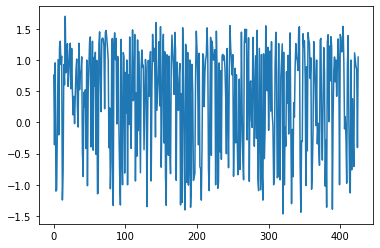

In [28]:
plt.plot(clf.decision_function(KLtr))

In [45]:
# Binary classification problem
random_state = np.random.RandomState(0)
X_bin, Y_bin =  make_classification(n_samples=1000,
                            n_features=50,
                            n_informative=10,
                            n_redundant=10,
                            n_repeated=10,
                            n_classes=2,
                            n_clusters_per_class=5,
                            weights=None,
                            flip_y=0.0,
                            class_sep=0.5,
                            hypercube=True,
                            shift=0.0,
                            scale=1.0,
                            shuffle=True,
                            random_state=random_state)

# X_bin = matrix(X)
# Y_bin = matrix([1.0 if y>0 else -1.0 for y in Y])

In [46]:
#train/test split
from sklearn.model_selection import train_test_split
Xtr,Xte,Ytr,Yte = train_test_split(X_bin,Y_bin, test_size=.25, random_state=42)
print ('done')

done


In [90]:
# Train & Test:
#train/test split
from sklearn.model_selection import train_test_split
Xtr,Xte,Ytr,Yte = train_test_split(X,Y, test_size=.25, random_state=42)



# # Generation of the weak Kernels:
klist = [rbf_kernel(X[:,f], gamma = 0.1) for f in featlist]
klisttr = [matrix(k)[idtrain,idtrain] for k in klist]
klistte = [matrix(k)[idtest,idtrain] for k in klist] 

IndexError: index 33 is out of bounds for axis 1 with size 30

In [91]:
# Selected features for each weak kernel:
featlist = [[random_state.randint(0,X_bin.size[1]) for i in range(5)] for j in range(20)]

TypeError: 'int' object is not subscriptable

In [82]:
X = matrix(X)
Y = matrix([1.0 if y>0 else -1.0 for y in Y])


# # Train & Test:
pertr = int(90)
idtrain = range(0,int(len(Y) * pertr / 100))
idtest = range(int(len(Y) * pertr / 100),len(Y))

Ytr = Y[0:idtest[0]]
Yte = Y[idtrain[-1]+1:1000]

# # Selected features for each weak kernel:
featlist = [[random_state.randint(0,X.size[1]) for i in range(5)] for j in range(50)]

In [84]:
# Generation of the weak Kernels:
klist = [rbf_kernel(X[:,f], gamma = 0.1) for f in featlist]
klisttr = [matrix(k)[idtrain,idtrain] for k in klist]
klistte = [matrix(k)[idtest,idtrain] for k in klist] 

TypeError: invalid index argument

In [80]:
idtrain[1]+1

2